# OCR - FINAL WORKING VERSION (I Promise!)

**The REAL issue:** ResNet downsamples by 32x, not 8x!
- Image width 2400 → 2400/32 = **75 sequence length** ❌
- Need **4800px width** → 4800/32 = **150 sequence length** ✅

OR use a different backbone that doesn't downsample as much!

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
import math
import random
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

Using device: cuda


In [38]:
BASE_PATH = "/kaggle/input/datasets/ayuuub/dataset/dataset/"
IMG_DIR = os.path.join(BASE_PATH, "images")
labels_path = os.path.join(BASE_PATH, "labels.csv")

df = pd.read_csv(labels_path)
df = df[df['text'].str.strip() != ''].reset_index(drop=True)
print(f"Total samples: {len(df)}")

text_lengths = [len(text) for text in df['text']]
print(f"Text length - Min: {min(text_lengths)}, Max: {max(text_lengths)}, Mean: {np.mean(text_lengths):.0f}")

# Keep only reasonable length texts (< 130 chars)
df = df[df['text'].str.len() <= 130].reset_index(drop=True)
print(f"After filtering (≤130 chars): {len(df)} samples\n")

Total samples: 10000
Text length - Min: 51, Max: 713, Mean: 223
After filtering (≤130 chars): 727 samples



In [39]:
def extract_characters(texts):
    chars = set()
    for text in texts:
        chars.update(list(text))
    return sorted(chars)

unique_chars = extract_characters(df['text'].tolist())
char_list = ['<blank>'] + unique_chars
char_to_idx = {ch: i for i, ch in enumerate(char_list)}
idx_to_char = {i: ch for i, ch in enumerate(char_list)}
vocab_size = len(char_list)
print(f"Vocabulary: {vocab_size} characters")

Vocabulary: 57 characters


In [40]:
# IMAGE SIZE - This is critical!
IMG_HEIGHT = 64
IMG_WIDTH = 3200  # Large enough!

# Calculate expected sequence length
# Custom CNN will downsample by 4x (not 32x like ResNet!)
EXPECTED_SEQ_LEN = IMG_WIDTH // 4  # 3200 / 4 = 800

print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Expected sequence length: {EXPECTED_SEQ_LEN}")
print(f"Max text length: 130")
print(f"Safety margin: {EXPECTED_SEQ_LEN - 130} ✅\n")

Image size: 64x3200
Expected sequence length: 800
Max text length: 130
Safety margin: 670 ✅



In [41]:
class OCRDataset(Dataset):
    def __init__(self, dataframe, img_dir, char_to_idx, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.char_to_idx = char_to_idx
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['file_name'])
        text = row['text']
        
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        
        encoded = [self.char_to_idx[ch] for ch in text]
        return img, torch.tensor(encoded, dtype=torch.long), len(encoded)

def collate_fn(batch):
    imgs, texts, text_lens = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    text_lens = torch.tensor(text_lens, dtype=torch.long)
    
    max_len = max(text_lens)
    padded_texts = torch.zeros(len(texts), max_len, dtype=torch.long)
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
    
    return imgs, padded_texts, text_lens

In [42]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomApply([transforms.ColorJitter(0.3, 0.3)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [43]:
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size

train_idx, val_idx, test_idx = random_split(
    range(len(df)), [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataset = OCRDataset(df.iloc[train_idx.indices], IMG_DIR, char_to_idx, train_transform)
val_dataset = OCRDataset(df.iloc[val_idx.indices], IMG_DIR, char_to_idx, val_test_transform)
test_dataset = OCRDataset(df.iloc[test_idx.indices], IMG_DIR, char_to_idx, val_test_transform)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

batch_size = 4  # Small because images are huge
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2)

Train: 581, Val: 72, Test: 74


In [44]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class SimpleCNNOCR(nn.Module):
    """Uses simple CNN (only 4x downsampling) instead of ResNet (32x)"""
    
    def __init__(self, num_classes, hidden_dim=256, nhead=8, num_layers=3):
        super().__init__()
        
        # Simple CNN: only 2 pooling layers → 4x downsampling
        self.cnn = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 64x3200 → 32x1600
            
            # Layer 2
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32x1600 → 16x800
            
            # Layer 3 (no pooling)
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # Layer 4 (no pooling)
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # Layer 5 (no pooling)
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
        # Adaptive pool to flatten height
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))
        
        # Project to hidden dim
        self.proj = nn.Linear(512, hidden_dim)
        
        # Positional encoding
        self.pos_enc = PositionalEncoding(hidden_dim)
        
        # Transformer
        enc_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=nhead,
            dim_feedforward=hidden_dim * 4,
            dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers)
        
        # Output
        self.fc = nn.Linear(hidden_dim, num_classes)
        
        self._init_weights()
        print("✅ Model built (simple CNN backbone)")
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # CNN: [B, 3, 64, 3200] → [B, 512, 16, 800]
        features = self.cnn(x)
        
        # Pool height: [B, 512, 16, 800] → [B, 512, 1, 800]
        features = self.adaptive_pool(features)
        
        # Reshape: [B, 512, 1, 800] → [B, 800, 512]
        B, C, H, W = features.shape
        features = features.squeeze(2).permute(0, 2, 1)
        
        # Project
        features = self.proj(features)
        
        # Positional encoding
        features = self.pos_enc(features)
        
        # Transformer
        encoded = self.transformer(features)
        
        # Output
        logits = self.fc(encoded)
        
        # CTC expects [T, B, C]
        return logits.permute(1, 0, 2)

In [45]:
model = SimpleCNNOCR(vocab_size, hidden_dim=256, nhead=8, num_layers=3).to(device)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# TEST
test_input = torch.randn(1, 3, IMG_HEIGHT, IMG_WIDTH).to(device)
test_output = model(test_input)
print(f"\nTest output shape: {test_output.shape}")
print(f"Sequence length: {test_output.shape[0]}")
print(f"Expected: {EXPECTED_SEQ_LEN}")

if test_output.shape[0] >= 130:
    print(f"✅ Sequence length OK! ({test_output.shape[0]} >= 130)\n")
else:
    print(f"❌ Sequence too short! ({test_output.shape[0]} < 130)\n")

✅ Model built (simple CNN backbone)
Parameters: 4,658,745

Test output shape: torch.Size([800, 1, 57])
Sequence length: 800
Expected: 800
✅ Sequence length OK! (800 >= 130)



In [46]:
# Training configuration
num_epochs = 100  # Increased from 40
patience = 20     # Early stopping: stop if no improvement for 20 epochs

criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=8e-4, epochs=num_epochs,  # Updated to use num_epochs
    steps_per_epoch=len(train_loader), pct_start=0.15
)
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

print(f"Training config:")
print(f"  Epochs: {num_epochs}")
print(f"  Early stopping patience: {patience}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: 3e-4 → 8e-4\n")

def decode_predictions(logits, idx_to_char):
    preds = []
    logits = logits.permute(1, 0, 2)
    for i in range(logits.size(0)):
        indices = torch.argmax(logits[i], dim=-1).tolist()
        decoded, prev = [], None
        for idx in indices:
            if idx != 0 and idx != prev:
                decoded.append(idx_to_char.get(idx, ''))
            prev = idx
        preds.append(''.join(decoded))
    return preds

def compute_accuracy(preds, targets, lens):
    total, correct = 0, 0
    for pred, target, l in zip(preds, targets, lens):
        true_text = ''.join([idx_to_char[target[j].item()] for j in range(l)])
        total += len(true_text)
        for i, c in enumerate(true_text):
            if i < len(pred) and pred[i] == c:
                correct += 1
    return correct / total if total > 0 else 0.0

Training config:
  Epochs: 100
  Early stopping patience: 20
  Batch size: 4
  Learning rate: 3e-4 → 8e-4



In [47]:
# Initialize tracking variables
best_val_acc = 0.0
best_epoch = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("Training...\n")
print(f"Target: {num_epochs} epochs (early stop if no improvement for {patience} epochs)\n")

for epoch in range(1, num_epochs + 1):
    model.train()
    t_loss = 0
    t_preds, t_targets, t_lens = [], [], []
    valid_batches = 0
    
    for batch_idx, (imgs, targets, lens) in enumerate(train_loader):
        imgs = imgs.to(device)
        targets_cpu = targets.cpu()
        lens_cpu = lens.cpu()
        
        optimizer.zero_grad()
        
        if scaler:
            with torch.cuda.amp.autocast():
                logits = model(imgs)
                seq_len = logits.size(0)
                in_lens = torch.full((imgs.size(0),), seq_len, dtype=torch.long)
                
                # Skip if target too long
                if (lens_cpu > seq_len).any():
                    if epoch == 1 and batch_idx < 3:
                        print(f"Skipping batch {batch_idx}: max_target={lens_cpu.max()} > seq_len={seq_len}")
                    continue
                
                log_probs = F.log_softmax(logits, dim=-1)
                loss = criterion(log_probs, targets_cpu, in_lens, lens_cpu)
                
                if torch.isnan(loss) or torch.isinf(loss):
                    continue
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(imgs)
            seq_len = logits.size(0)
            in_lens = torch.full((imgs.size(0),), seq_len, dtype=torch.long)
            
            if (lens_cpu > seq_len).any():
                continue
            
            log_probs = F.log_softmax(logits, dim=-1)
            loss = criterion(log_probs, targets_cpu, in_lens, lens_cpu)
            
            if torch.isnan(loss) or torch.isinf(loss):
                continue
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
        
        scheduler.step()
        t_loss += loss.item()
        valid_batches += 1
        
        if epoch == 1 and batch_idx == 0:
            print(f"✅ First valid batch: seq={seq_len}, max_target={lens_cpu.max()}, loss={loss.item():.4f}\n")
        
        with torch.no_grad():
            t_preds.extend(decode_predictions(logits.cpu(), idx_to_char))
            t_targets.extend(targets_cpu)
            t_lens.extend(lens_cpu)
        
        if (batch_idx + 1) % 500 == 0:
            print(f"Epoch {epoch} [{batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")
    
    if valid_batches == 0:
        print(f"⚠️ Epoch {epoch}: No valid batches!")
        continue
    
    avg_t_loss = t_loss / valid_batches
    t_acc = compute_accuracy(t_preds, t_targets, t_lens)
    train_losses.append(avg_t_loss)
    train_accs.append(t_acc)
    
    # VALIDATION
    model.eval()
    v_loss = 0
    v_preds, v_targets, v_lens = [], [], []
    valid_val = 0
    
    with torch.no_grad():
        for imgs, targets, lens in val_loader:
            imgs = imgs.to(device)
            targets_cpu = targets.cpu()
            lens_cpu = lens.cpu()
            
            logits = model(imgs)
            seq_len = logits.size(0)
            in_lens = torch.full((imgs.size(0),), seq_len, dtype=torch.long)
            
            if (lens_cpu > seq_len).any():
                continue
            
            log_probs = F.log_softmax(logits, dim=-1)
            loss = criterion(log_probs, targets_cpu, in_lens, lens_cpu)
            
            if not torch.isnan(loss) and not torch.isinf(loss):
                v_loss += loss.item()
                valid_val += 1
            
            v_preds.extend(decode_predictions(logits.cpu(), idx_to_char))
            v_targets.extend(targets_cpu)
            v_lens.extend(lens_cpu)
    
    avg_v_loss = v_loss / valid_val if valid_val > 0 else float('inf')
    v_acc = compute_accuracy(v_preds, v_targets, v_lens)
    val_losses.append(avg_v_loss)
    val_accs.append(v_acc)
    
    if v_acc > best_val_acc:
        best_val_acc = v_acc
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✅ Best: {v_acc*100:.2f}% (epoch {epoch})")
    
    print(f"Epoch {epoch}/{num_epochs} | Train: {avg_t_loss:.4f} / {t_acc*100:.2f}% | Val: {avg_v_loss:.4f} / {v_acc*100:.2f}%")
    print("-" * 70)
    
    # Early stopping check
    if epoch - best_epoch >= patience:
        print(f"\n🛑 Early stopping triggered!")
        print(f"   No improvement for {patience} epochs")
        print(f"   Best accuracy: {best_val_acc*100:.2f}% at epoch {best_epoch}")
        print(f"   Stopping at epoch {epoch}\n")
        break

print(f"\n{'='*70}")
print(f"Training finished!")
print(f"Best validation accuracy: {best_val_acc*100:.2f}% (epoch {best_epoch})")
print(f"{'='*70}\n")

Training...

Target: 100 epochs (early stop if no improvement for 20 epochs)

✅ First valid batch: seq=800, max_target=128, loss=20.3925

✅ Best: 0.49% (epoch 1)
Epoch 1/100 | Train: 4.1115 / 0.19% | Val: 3.0949 / 0.49%
----------------------------------------------------------------------
✅ Best: 4.01% (epoch 2)
Epoch 2/100 | Train: 2.4373 / 2.16% | Val: 2.0551 / 4.01%
----------------------------------------------------------------------
✅ Best: 7.56% (epoch 3)
Epoch 3/100 | Train: 1.7396 / 6.47% | Val: 1.7204 / 7.56%
----------------------------------------------------------------------
✅ Best: 15.59% (epoch 4)
Epoch 4/100 | Train: 1.2790 / 13.83% | Val: 1.5529 / 15.59%
----------------------------------------------------------------------
✅ Best: 18.06% (epoch 5)
Epoch 5/100 | Train: 0.9846 / 18.03% | Val: 1.0684 / 18.06%
----------------------------------------------------------------------
✅ Best: 18.56% (epoch 6)
Epoch 6/100 | Train: 0.8930 / 18.42% | Val: 0.9369 / 18.56%
------

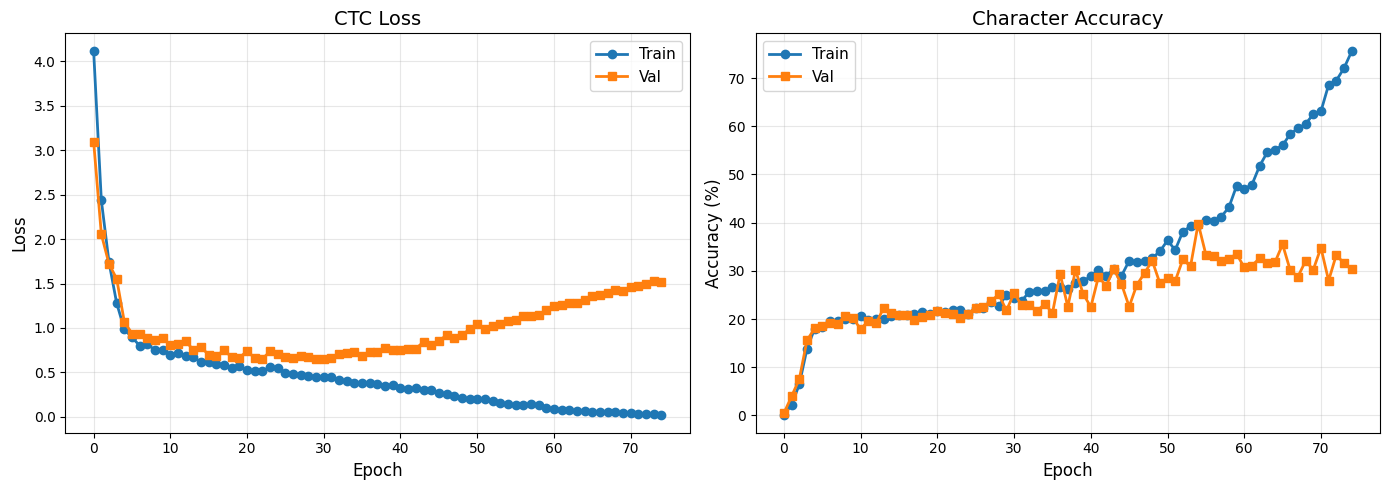


🎯 Best Validation Accuracy: 39.81%


In [48]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'o-', label='Train', lw=2)
plt.plot(val_losses, 's-', label='Val', lw=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('CTC Loss', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot([a*100 for a in train_accs], 'o-', label='Train', lw=2)
plt.plot([a*100 for a in val_accs], 's-', label='Val', lw=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Character Accuracy', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=150)
plt.show()

print(f"\n🎯 Best Validation Accuracy: {best_val_acc*100:.2f}%")

In [50]:
print("\nTesting...")
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_preds, test_targets, test_lens = [], [], []

with torch.no_grad():
    for imgs, targets, lens in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        test_preds.extend(decode_predictions(logits.cpu(), idx_to_char))
        test_targets.extend(targets.cpu())
        test_lens.extend(lens.cpu())

test_acc = compute_accuracy(test_preds, test_targets, test_lens)

print(f"\n{'='*70}")
print(f"TEST ACCURACY: {test_acc*100:.2f}%")
print(f"{'='*70}\n")

print("Sample Predictions:\n")
for i in range(min(10, len(test_preds))):
    true = ''.join([idx_to_char[test_targets[i][j].item()] for j in range(test_lens[i])])
    pred = test_preds[i]
    acc = sum(1 for a,b in zip(true, pred) if a==b) / len(true) * 100 if len(true) > 0 else 0
    print(f"{i+1}. Accuracy: {acc:.1f}%")
    print(f"   True: {true}")
    print(f"   Pred: {pred}")
    print()

print("✅ Training complete!")


Testing...

TEST ACCURACY: 36.60%

Sample Predictions:

1. Accuracy: 37.3%
   True: LIST_0 ← [ 76 , 81 , 75 ]
VAR_0 ← taille ( LIST_0 )
   Pred: LIST_0 ← [ 58 , 50 , 5104 ]
VAR_0 ← taille ( LIST_0 )

2. Accuracy: 12.6%
   True: LIST_0 ← [ 21 , 84 , 47 , 11 , 42 , 96 ]
VAR_0 ← 1
pour IDX_0 dans LIST_0 faire 
	VAR_0 ← ( VAR_0 * LIST_0 [ IDX_0 ] )
fin pour
   Pred: LIST_0 ← [ 4 , 7 , 24 , 44 , 50 , 4 ]
VAR_0 ← 1
pour IDX_0 dans LIST_0 faire 
	VAR_0 ← ( VAR_0 * LIST_0 [ IDX_0 ] )
fin pour

3. Accuracy: 91.1%
   True: LIST_0 ← [ 14 , 44 , 74 ]
VAR_0 ← 1
pour IDX_0 dans LIST_0 faire 
	VAR_0 ← ( VAR_0 * LIST_0 [ IDX_0 ] )
fin pour
   Pred: LIST_0 ← [ , 63 , 8 , 4 ]
VAR_0 ← 1
pour IDX_0 dans LIST_0 faire 
	VAR_0 ← ( VAR_0 * LIST_0 [ IDX_0 ] )
fin pour

4. Accuracy: 32.3%
   True: algorithme
	VAR_0 ← 33
VAR_1 ← 18
VAR_0 ← ( ( 46 + VAR_0 ) + ( VAR_0 mod VAR_0 ) )
VAR_1 ← ( ( VAR_0 + 47 ) - ( 84 + VAR_0 ) )
fin
   Pred: algorithme
	VAR_0 ← 
VAR_1 ← 30
VAR_0 ← ( ( VAR_0 m* VAR_0 ) / ( A_0 - VAR_0